# Talbot plane counting
Another notebook in the series of analysis of Mark's trap array design. Here I count how many Talbot planes form for a small array. 

In [2]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

In [3]:
## physics and lens params
lmbda = 8.13e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.01
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 2.4e-4 # spot radius
dx = 3*a # grid periodicity
dy = dx 
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum = ynum = 4 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

b=0.002066, a=0.00024, dx=0.00072, dy=0.00072, xnum=4, ynum=4
zTalbotx=0.000128, zTalboty=0.000128


202 808 202 808


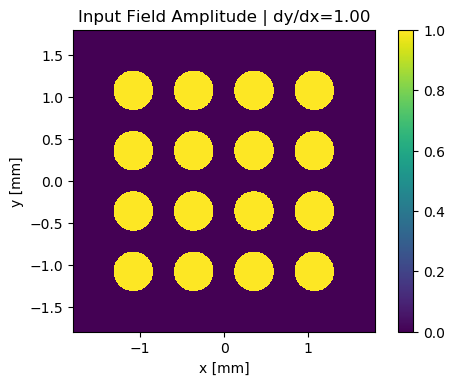

In [8]:
pts = 1011
phi_std=None # [rad]
pos_std=None
r_aper = 0 #1/sqrt(1.778232201710943) # 1.778 is the bright spot peak intensity per input intensity. r_aper ~ .75. 
t_plate = 0 # plate transmissivity
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)
fig,ax = figax(xlabel=r'x [mm]', ylabel=r'y [mm]')
fig.dpi=100
ax.set_title(rf'Input Field Amplitude | dy/dx={dy/dx:0.2f}') #$t_{{spot}}$={1-r_aper:0.2f}, $t_{{plate}}$={t_plate:0.2f}',)
mmscl = 1e3
cax = ax.imshow(abs(mask), extent=[-w*mmscl,w*mmscl,-w*mmscl,w*mmscl])
cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)

# need to figure out FFT scaling to give output intensity the same as input intensity

In [32]:
for tp_idx in range(5): # iterate over talbot planes; 0 is focal plane
    z2 = f2 + tp_idx*zTalbotx
    print(int((z2 - f2)/zTalbotx+0.5), (z2 - f2)/zTalbotx)

0 0.0
1 1.0000000000000053
2 1.9999999999999971
3 3.000000000000002
4 3.9999999999999942


In [9]:
plt.close()
savefile=True

# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding = int(1.5*pts)
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,mask,b,f1,k,x0pts,rr0,padding, masked=False,padval=1)

# OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2
rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
for tp_idx in range(9): # iterate over talbot planes; 0 is focal plane
    z2 = f2 + tp_idx*zTalbotx
    field2,x2pts = lens_xform(z2,field1,b,f2,k,x1pts,rr1,padding,masked=True)

    I2_xy = conjugate(field2)*field2
    if f2 - z2 == 0:
        I2xy_max = amax(I2_xy)
        r = 1/sqrt(I2xy_max)
    I2_xy = I2_xy/I2xy_max

    scl = 1e6
    fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
    fig.dpi=100
    if z2-f2 == 0:
        planestr = "Focal plane"
        fplanestr = "focus" 
    else:
        planestr = f'Talbot plane {int((z2 - f2)/zTalbotx+0.5)}'
        fplanestr = f"talbot{int((z2 - f2)/zTalbotx+0.5)}"
    title = planestr
    title += f' | d={int(dx/a)}a' #Uniform input $\phi$
    if z2-f2 != 0:
        title += f' | Max I={amax(real(I2_xy)):.2f}'
        title += '\n Normalized to focal plane intensity'
    ax.set_title(title)
    if f2 - z2 == 0:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    else:
        cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
    # fig.colorbar(cax, ticks=arange(0,1.2,.2))
    fig.colorbar(cax)
    
    fname = f'{xnum}x{ynum}_bright_grid_{fplanestr}.png'
    if savefile:
        plt.savefig(fname, bbox_inches='tight')
        print('wrote file to',fname)
        plt.close()

f - z2 = 0
calculated field2 in 4.33519983291626 s
f - z2 = 0.0
calculated field2 in 4.55482816696167 s
wrote file to 4x4_bright_grid_focus.png
f - z2 = -0.00012752767527675346
calculated field2 in 4.426168203353882 s
wrote file to 4x4_bright_grid_talbot1.png
f - z2 = -0.0002550553505535052
calculated field2 in 4.503959894180298 s
wrote file to 4x4_bright_grid_talbot2.png
f - z2 = -0.00038258302583025865
calculated field2 in 4.917011022567749 s
wrote file to 4x4_bright_grid_talbot3.png
f - z2 = -0.0005101107011070104
calculated field2 in 5.11393928527832 s
wrote file to 4x4_bright_grid_talbot4.png
f - z2 = -0.0006376383763837638
calculated field2 in 4.9811317920684814 s
wrote file to 4x4_bright_grid_talbot5.png
f - z2 = -0.0007651660516605173
calculated field2 in 4.926648139953613 s
wrote file to 4x4_bright_grid_talbot6.png
f - z2 = -0.000892693726937269
calculated field2 in 4.998368740081787 s
wrote file to 4x4_bright_grid_talbot7.png
f - z2 = -0.0010202214022140225
calculated field2 

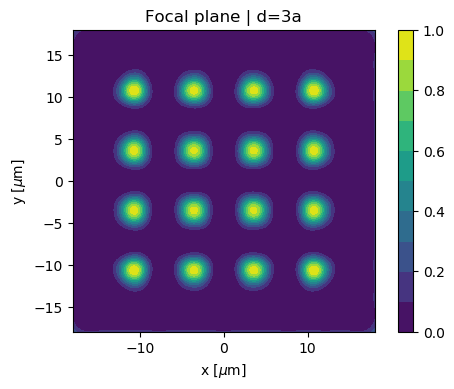

In [16]:
scl = 1e6
fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
fig.dpi=100
if z2-f2 == 0:
    planestr = "Focal plane"
else:
    planestr = f'Talbot plane {int((z2 - f2)/zTalbotx)}'
title = planestr
title += f' | d={int(dx/a)}a' #Uniform input $\phi$
if z2-f2 != 0:
    title += f'Maxima={amax(real(I2_xy)):.2f}'
    title += '\n Normalized to focal plane intensity'
ax.set_title(title)
if f2 - z2 == 0:
    cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
else:
    cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
# fig.colorbar(cax, ticks=arange(0,1.2,.2))
fig.colorbar(cax)